## Imports/Setup

In [2]:
%run ../00_functions/00_custom_functions.ipynb
standard_setup(extra_packages=True, verbose=False)
data_ingestion_prep(start_yearmonth='1979-01', end_yearmonth='2022-12', verbose=False)

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk
Files will be outputed as: .nc
ECMWF CDS API key already installed


## Collection: Ocean Carbon (pCO2 / fCO2)

#### SOCAT

In [ ]:
#pCO2 data is calculated from fCO2 and SST (SOCOVV) and sea level pressure (ECMRWF) so we need to obtain a dataset for both

#fCO2 and SST comes from the Surface Ocean CO2 Variability and Vulnerability group (1970-01 to end of last year only)
#We want to use the same SST data points related to fCO2 from the same source (not using the separate NOAA SST here).
#More info can be found at https://www.socat.info/index.php/data-access/
fco2_direct_url = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0278913/SOCATv2023_Gridded_Dat/SOCATv2023_tracks_gridded_monthly.nc'  #thru 2022-12
      #previously 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0253659/SOCATv2022_Gridded_Dat/SOCATv2022_tracks_gridded_monthly.nc'  #thru 2021-12
fco2_destination_folder = global_vars['download_folder']+r'pCO2/originals/'    
fco2_destination_filename = 'fCO2_SOCOVV_SOCAT-gridded-monthly_2022.nc'    #filename year changed from source to denote data date, not publish date
download(fco2_direct_url, fco2_destination_folder, fco2_destination_filename)

#### Coastal Filling (pCO2)

In [15]:
#This data set is used for enhancing coastal areas for flux calculation
#More info can be found https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0209633 and https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0209633/
coastal_clim_direct = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0209633/MPI-ULB-SOM_FFN_clim.nc'
coastal_clim_destination_folder = global_vars['download_folder']+r'pCO2/originals/' 
coastal_clim_filename = 'pCO2_NOAA-NCEI_MPI-ULB-SOM-FFN_1988-2020.nc'
download(coastal_clim_direct, coastal_clim_destination_folder, coastal_clim_filename)

File pCO2_NOAA-NCEI_MPI-ULB-SOM-FFN_1988-2020.zarr already exists at gs://leap-persistent/ds4114/online_data/pCO2/originals/ - (skipping download from https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0209633/MPI-ULB-SOM_FFN_clim.nc )


#### Global Carbon Budget - Global Ocean Biogeochemistry Models (GOBM)

In [4]:
#This data is not downloaded publically and is recieved via email. The result is below as an example.

#TBD where to download and where to save
xr_open_dataset_custom('/data/artemis/simulations/GCB/2023models/GCB-2023_models_sfco2_simA_1959-2022.nc')

<xarray.Dataset>
Dimensions:         (time: 768, lon: 360, lat: 180)
Coordinates:
  * time            (time) datetime64[ns] 1959-01-15 1959-02-15 ... 2022-12-15
  * lon             (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    CNRM-ESM2-1     (time, lat, lon) float64 ...
    FESOM2-REcoM    (time, lat, lon) float64 ...
    IPSL            (time, lat, lon) float64 ...
    MOM6-Princeton  (time, lat, lon) float64 ...
    MRI-ESM2-2      (time, lat, lon) float64 ...
    NorESM-OC1.2    (time, lat, lon) float64 ...
    CESM-ETHZ       (time, lat, lon) float64 ...
    ACCESS          (time, lat, lon) float64 ...

## Processing: Ocean Carbon (pCO2 / fCO2)

#### SOCAT

In [3]:
socat = xr_open_dataset_custom(global_vars['download_folder']+r'pCO2/originals/fCO2_SOCOVV_SOCAT-gridded-monthly_2022.nc') 
mslp_out = xr_open_dataset_custom(global_vars['download_folder']+r'/SLP/processed/SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP_198201-202304.nc')

In [97]:
#get relevant variables and filter for desired years 
co2_processed_end_yearmonth = socat.tmnth.max().data.astype('datetime64[s]').item().strftime('%Y-%m') #Note that fCO2 is only up til 2 years ago if (released every June)
fco2 = socat.fco2_ave_weighted
fco2 = fco2.sel(tmnth=slice(str(processed_start_yearmonth),str(co2_processed_end_yearmonth))) 
fco2_sst = socat.sst_ave_weighted
fco2_sst = fco2_sst.sel(tmnth=slice(str(processed_start_yearmonth),str(co2_processed_end_yearmonth)))
fco2_mslp = mslp_out.mslp  #from ERA5 section above
fco2_mslp = fco2_mslp.sel(time=slice(str(processed_start_yearmonth),str(co2_processed_end_yearmonth)))

In [98]:
#For anlaysis, we only need fco2; however we are including a pco2 variable for additional validation and testing
    #example: fCO2_to_pCO2(380, 8) #381.5
pco2 = fCO2_to_pCO2(fco2, fco2_sst, fco2_mslp, tempEQ_C=None)
pco2 = np.where((pco2>200)&(pco2<650),pco2,np.nan) #where socat pco2 values are <200 and >650 we are changing to nans as a source of quality control
fco2 = xr.where((fco2>200)&(fco2<650),fco2,np.nan)

In [99]:
#Realign time to our grid for each available month (ex shift from 16th to 15th for consistency)
fco2_ttime = ttime[pd.DataFrame(ttime,columns=['t']).t.between(fco2.tmnth.min().data.astype('datetime64[s]').item().strftime('%Y-%m'), fco2.tmnth.max().data.astype('datetime64[s]').item(), inclusive='both')]
    #Alternatively can use this: fco2_ttime = pd.date_range(start=fco2.tmnth.min().item(), end=fco2.tmnth.max().item(),freq='MS') + np.timedelta64(14, 'D')
#fco2_ttime

In [103]:
pco2_out = xr.Dataset(  {
                        'pco2':(["time","ylat","xlon"],pco2.data),
                        #'socat_mask':(["time","ylat","xlon"],np.where(~np.isnan(pco2),1,np.nan)),  #Prior code included additional variables which are not needed
                        #'socat_sst':(["time","ylat","xlon"],fco2_sst.data),
                        #'mslp':(["time","ylat","xlon"],fco2_mslp.data),
                        'fco2':(["time","ylat","xlon"],fco2.data)
                        },
                        coords={'time': (['time'],fco2_ttime.values),
                          'ylat': (['ylat'],fco2.ylat.data),
                          'xlon': (['xlon'],fco2.xlon.data)}
                    )
pco2_out.pco2.attrs['units'] = 'uatm'
pco2_out.pco2.attrs['description'] = 'uses fco2 (weighted), sst (weighted) and MSLP to convert to pCO2 via fCO2_to_pCO2 script'
pco2_out.pco2.attrs['description2'] = 'socat pco2 and fco2 values <200 and >650 have been changed to nans as a source of quality control' 
#pco2_out.socat_sst.attrs['units'] = 'deg C'
#pco2_out.mslp.attrs['units'] = 'hPa'
pco2_out.fco2.attrs['units'] = 'uatm'
#pco2_out

In [110]:
output_xarray_with_date(pco2_out.chunk(-1), global_vars['download_folder']+'pCO2/processed/', 'pCO2_LEAP_SOCAT-ERA5-fco2-weighted-gridded', output_file_type)

Saved pCO2_LEAP_SOCAT-ERA5-fco2-weighted-gridded_198201-202212.nc to /data/artemis/workspace/ds4114/online_data/pCO2/processed/


/tmp/ipykernel_25882/2521619570.py:2: RuntimeWarning: All-NaN axis encountered
  plt.contourf(ideal_grid.longitude,ideal_grid.latitude,np.nanmax(pco2_out.fco2, axis=0))


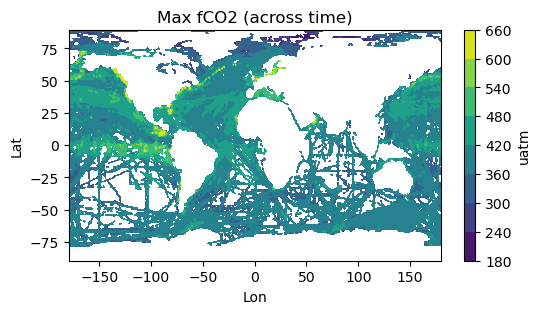

In [105]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.contourf(ideal_grid.longitude,ideal_grid.latitude,np.nanmax(pco2_out.fco2, axis=0)) 
plt.title('Max fCO2 (across time)'); plt.xlabel('Lon'); plt.ylabel('Lat')
plt.colorbar().set_label('uatm');

#### Coastal Fill pCO2

In [106]:
coastal_clim = xr_open_dataset_custom(global_vars['download_folder'] + 'pCO2/originals/pCO2_NOAA-NCEI_MPI-ULB-SOM-FFN_1988-2020.nc')

In [107]:
coastal_clim = coastal_clim.where(coastal_clim != -999) #fill negative values (land) with nan

#Regrid
coastal_clim_regridder = xesmf.Regridder(coastal_clim, ideal_grid, 'conservative', periodic=True)  #see notes above on why conservative over bilinear
coastal_clim_out = coastal_clim_regridder(coastal_clim.chunk(-1), keep_attrs=True)
#coastal_clim_out

In [108]:
#convert pco2 to fco2
#The data is centered on 2006 so we'll convert this Landschutzer climatology product to fco2 using inputs for the year 2006 from SLP and SST
#Note that this requires SST and SLP from above
coastal_clim_out_fco2 = pCO2_to_fCO2(coastal_clim_out.pco2, 
                                     sst_out.sst.sel(time=slice(str('2006-01'),str('2006-12'))),
                                     mslp_out.mslp.sel(time=slice(str('2006-01'),str('2006-12'))),
                                     tempEQ_C=None)

In [109]:
#we now have 12 months of coastal fco2 data, let's replicate for the desired time frame so merging is easier later
coastal_out_full_fco2 = np.empty(shape=(len(ttime),180,360)) 
#now fill array with climatology
for i, m in enumerate(ttime): 
    coastal_out_full_fco2[i,:,:] = coastal_clim_out_fco2[m.month-1,:,:]
#coastal_out_full_fco2

In [111]:
coastal_out_full_fco2_xr = xr.Dataset({'fco2':(["time","ylat","xlon"],coastal_out_full_fco2.data)},
                    coords={'time': (['time'],ttime.values),'ylat':(['ylat'],ideal_grid.latitude.data),'xlon':(['xlon'],ideal_grid.longitude.data)})
coastal_out_full_fco2_xr.fco2.attrs['description'] = 'uses pco2, NOAA sst and ERA5 MSLP to convert pCO2 to fCO2 using pCO2_to_fCO2 script'
coastal_out_full_fco2_xr.fco2.attrs['units'] = 'uatm'

In [112]:
output_xarray_with_date(coastal_out_full_fco2_xr, global_vars['download_folder']+'pCO2/processed/', 'fCO2_NOAA-NCEI_MPI-ULB-SOM-FFN', output_file_type)

Cancelling output - fCO2_NOAA-NCEI_MPI-ULB-SOM-FFN_198201-202304.nc already exists in /data/artemis/workspace/ds4114/online_data/pCO2/processed/


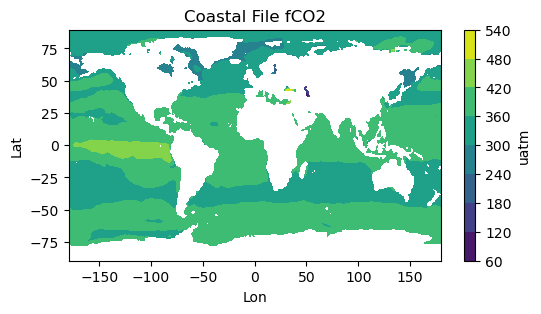

In [113]:
fig = plt.figure(figsize=(figsizew,figsizeh))
#plt.contourf(ideal_grid.longitude,ideal_grid.latitude,np.nanmax(coastal_out_full_fco2_xr.fco2, axis=0)) #max across time 
plt.contourf(ideal_grid.longitude,ideal_grid.latitude,coastal_out_full_fco2_xr.fco2.sel(time='2006-06-15')) #just one specific month
plt.title('Coastal File fCO2'); plt.xlabel('Lon'); plt.ylabel('Lat')
plt.colorbar().set_label('uatm');

#### Coastal - Back in Time

In [8]:
#for this we just need to replicate the residual code but make the climatology extend back to 1959. 
#We can just load that file and tile it for more years
coastal_out_full_fco2_xr = xr_open_dataset_custom(global_vars['download_folder'] +'pCO2/processed/fCO2_NOAA-NCEI_MPI-ULB-SOM-FFN_198201-202304.nc')
coastal_clim = coastal_out_full_fco2_xr.sel(time=slice(str('2000-01'),str('2000-12'))) #can be any year since same
coastal_clim = coastal_clim.rename({'time':'month'})

In [29]:
numb_years = (int(processed_end_yearmonth[0:4])+1) - int(processed_start_yearmonth_back_in_time[0:4])
coastal_clim_tiled = xr.broadcast( coastal_clim, xr.DataArray(np.ones([numb_years]), dims=("year")))[0]
coastal_clim_tiled = coastal_clim_tiled.stack(time=['year','month'])
coastal_clim_tiled = coastal_clim_tiled.transpose('time','ylat','xlon')

In [40]:
coastal_clim_back_in_time = xr.Dataset({'fco2':(['time','ylat','xlon'],coastal_clim_tiled.fco2.data)
                    },coords={'time':(['time'],ideal_grid_back_in_time.time.values),'ylat':(['ylat'],ideal_grid_back_in_time.latitude.values),'xlon':(['xlon'],ideal_grid_back_in_time.longitude.values)})
coastal_clim_back_in_time

<xarray.Dataset>
Dimensions:  (time: 768, ylat: 180, xlon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-15 1959-02-15 ... 2022-12-15
  * ylat     (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon     (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    fco2     (time, ylat, xlon) float64 nan nan nan nan ... 310.1 310.1 310.3

In [41]:
output_xarray_with_date(coastal_clim_back_in_time, global_vars['download_folder'] +'pCO2/processed/', 'fCO2_NOAA-NCEI_MPI-ULB-SOM-FFN', filetype=output_file_type)

Saved fCO2_NOAA-NCEI_MPI-ULB-SOM-FFN__195901-202212.nc to /data/artemis/workspace/ds4114/online_data/pCO2/processed/


#### Global Carbon Budget - Global Ocean Biogeochemistry Models (GOBM)

In [3]:
#assume this is the data from original source we downloaded
models= xr.open_dataset('/data/artemis/simulations/GCB/2023models/GCB-2023_models_sfco2_simA_1959-2022.nc')

In [4]:
models_cut = models.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth))) #already monthly so select desired years

#regrid to flip longitude
model_regridder = xesmf.Regridder(models_cut, ideal_grid_back_in_time, 'bilinear', periodic=True)  #data is already 1x1 but we want to shift coordinates
models_cut_out = model_regridder(models_cut, keep_attrs=True)
models_cut_out = models_cut_out.rename({'latitude': 'ylat','longitude': 'xlon'})
models_cut_out = models_cut_out.assign_coords(time=ttime_back_in_time) 

#cut further for just ML XGB optionally
#models_cut_out_xgb = models_cut_out_xgb.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth)))
#models_cut_out_xgb

In [6]:
#output 
output_xarray_with_date(models_cut_out,     os.path.join(global_vars['download_folder'],'GOBM/processed/'), 'GOBM_GCB-2023_fco2-8-models', filetype=output_file_type, overwrite=False)
#output_xarray_with_date(models_cut_out_xgb, os.path.join(global_vars['download_folder'],'GOBM/processed/'), 'GOBM_GCB-2023_fco2-8-models', filetype=output_file_type, overwrite=False)

Saved GOBM_GCB-2023_fco2-8-models_195901-202212.nc to /data/artemis/workspace/ds4114/online_data/GOBM/processed/
